# 1. Import Libraries and Load the Data

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# For reproducibility
np.random.seed(42)

# Load the dataset: change the filename/path as required.
data = pd.read_csv(r'C:\Users\ABC\Downloads\Airbnb_data - airbnb_data.csv')
data.head()


,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


# 2. Data Exploration and Preprocessing

### 2a. Preliminary Exploration and Cleaning 

In [3]:
# View dataset information to understand its structure.
print("Dataset info:")
print(data.info())

# Summary statistics for numerical features
print("Summary statistics:")
print(data.describe())

# Check for missing values across columns
print("Missing values in each column:")
print(data.isnull().sum())

# Remove duplicate rows if any
data.drop_duplicates(inplace=True)


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  

### 2b. Data Type Conversions and Feature Engineering

In [4]:
# Convert date columns to datetime objects when applicable.
date_cols = ['first_review', 'host_since_', 'last_review']
for col in date_cols:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col], dayfirst=True, errors='coerce')

# Example Feature Engineering: 
# Create a new feature 'amenities_count' based on the number of amenities listed.
if 'amenities' in data.columns:
    data['amenities_count'] = data['amenities'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)

# Convert 'host_response_rate' from a percentage string to numeric (if needed).
if 'host_response_rate' in data.columns:
    data['host_response_rate'] = data['host_response_rate'].str.rstrip('%').astype('float')


### 2c. Handling Missing Values and Outliers

In [5]:
# Fill missing values for numerical columns with the median value.
num_cols = data.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    data[col].fillna(data[col].median(), inplace=True)

# Fill missing values for categorical columns with the mode.
cat_cols = data.select_dtypes(include=['object']).columns
for col in cat_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)

# Outlier removal for the target variable 'log_price' using the IQR method.
if 'log_price' in data.columns:
    Q1 = data['log_price'].quantile(0.25)
    Q3 = data['log_price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data['log_price'] >= lower_bound) & (data['log_price'] <= upper_bound)]


C:\Users\ABC\AppData\Local\Temp\ipykernel_11420\1257603112.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
C:\Users\ABC\AppData\Local\Temp\ipykernel_11420\1257603112.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

### 2d. Define Features and Split the Data

In [6]:
# Define the target variable and select a set of relevant features.
target = 'log_price'
features = [
    'property_type', 'room_type', 'accommodates', 'bathrooms', 
    'bed_type', 'cancellation_policy', 'cleaning_fee', 'city',
    'amenities_count', 'host_response_rate', 'latitude', 'longitude',
    'bedrooms', 'beds', 'number_of_reviews', 'review_scores_rating'
]

# Ensure that we include only those features that exist in the dataset.
features = [col for col in features if col in data.columns]

# Separate the dataset into features (X) and target (y)
X = data[features]
y = data[target]

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# 3. Model Development

### 3a. Build a Preprocessing and Modeling Pipeline

In [7]:
# Identify numerical and categorical features for proper transformation.
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()

# Create a ColumnTransformer for scaling numerical features and one-hot encoding categorical features.
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Assemble the preprocessing and RandomForestRegressor into a Pipeline.
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])


### 3b. Train the Model

In [ ]:
# Fit the pipeline model on the training data.
model_pipeline.fit(X_train, y_train)


# 4. Model Evaluation

### 4a. Evaluate Predictions Using Regression Metrics

In [10]:
# Make predictions with the test set.
y_pred = model_pipeline.predict(X_test)

# Calculate evaluation metrics: RMSE, MAE, and R².
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R²: {r2:.4f}")


Test RMSE: 0.3624
Test MAE: 0.2694
Test R²: 0.6921


### 4b. Visualize Model Performance

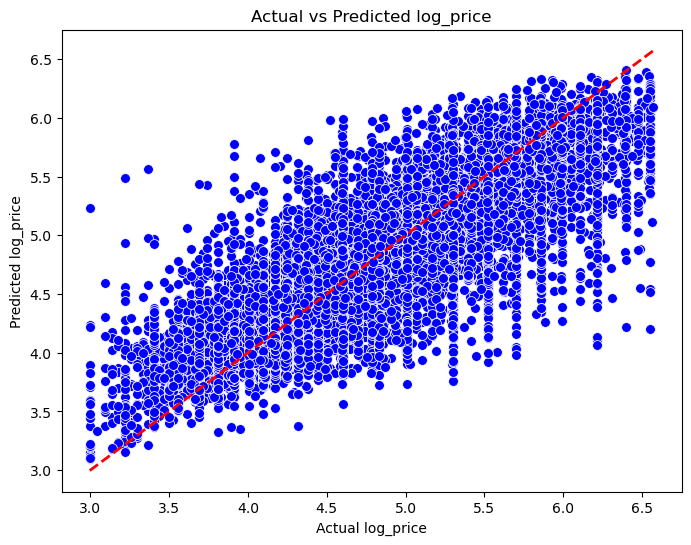

In [11]:
# Visualize the actual vs. predicted log_price values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue', s=50)
plt.xlabel('Actual log_price')
plt.ylabel('Predicted log_price')
plt.title('Actual vs Predicted log_price')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.show()


# Final presentation 

link of presentation :- https://drive.google.com/file/d/1ojNMfzoTAbE9ghTw2P8mmyNJUYKqQkGp/view?usp=sharing